# Recommender System with Collaborative Filtering

First, we need to read the data from the dataset.

In [1793]:
import pandas as pd
import numpy as np

In [1794]:
datasets_loc = "datasets"
# datasets_loc = "toy_datasets"

In [1795]:
ratings = pd.read_csv(datasets_loc + "/ratings.csv", delim_whitespace=True, skiprows=1, names=["UserID", "ProfileID", "Rating"])
# gender = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender"]) (For large dataset)
info = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender", "Name"])

Here is our data. UserID is the user, ProfileID is the profile that user is looking at.

In [1796]:
ratings.head()

/Users/andrew/opt/anaconda3/envs/ml/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [1797]:
info.head()

,UserID,Gender,Name
0,1,F,NaN
1,2,F,NaN
2,3,U,NaN
3,4,F,NaN
4,5,F,NaN


In [1798]:
ratings = pd.merge(info, ratings)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,8
1,1,F,NaN,720,6
2,1,F,NaN,971,10
3,1,F,NaN,1095,7
4,1,F,NaN,1616,10
...,...,...,...,...,...
17359341,135359,F,NaN,215145,8
17359342,135359,F,NaN,215718,4
17359343,135359,F,NaN,218646,10
17359344,135359,F,NaN,218857,7


We map the rating to like/ dislike. Rating smaller than 5 will consider as a dislike to the profile.

In [1799]:
ratings["Rating"] = np.where(ratings["Rating"] < 5, -1, 1)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,1
1,1,F,NaN,720,1
2,1,F,NaN,971,1
3,1,F,NaN,1095,1
4,1,F,NaN,1616,1
...,...,...,...,...,...
17359341,135359,F,NaN,215145,1
17359342,135359,F,NaN,215718,-1
17359343,135359,F,NaN,218646,1
17359344,135359,F,NaN,218857,1


Due to large data set, we need to reduce the data records.

In [1800]:
ratings = ratings[(ratings["UserID"] <= 10000) & (ratings["ProfileID"] <= 10000)]
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,1
1,1,F,NaN,720,1
2,1,F,NaN,971,1
3,1,F,NaN,1095,1
4,1,F,NaN,1616,1
...,...,...,...,...,...
1262053,10000,F,NaN,2255,-1
1262054,10000,F,NaN,3968,1
1262055,10000,F,NaN,6844,-1
1262056,10000,F,NaN,7724,1


# Preparing data for Collaborative Filtering  

In [1801]:
# Full list of rating
user_ratings = ratings.pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
user_ratings.head()

Rating                                                        ...  \
ProfileID  1     2     8     9     17    18    23    25    26    28     ...   
UserID                                                                  ...   
1            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

                                                                       
ProfileID 9986  9987  9988  9989  9990  9995  9996  9997  9998  10000  
UserID                                                                 
1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
6           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 4088 columns]

In [1802]:
# Clear pivot table structure to extra index and columns

user_ratings_df = user_ratings.copy()

user_ratings_df.columns = user_ratings_df.columns.droplevel(0)
user_ratings_df.name = None
user_ratings_df = user_ratings_df.reset_index()
user_ratings_df.index = user_ratings_df["UserID"]
user_ratings_df.index.name = "UserID"
user_ratings_df.drop("UserID", axis="columns", inplace=True)

user_ratings_df

ProfileID,1,2,8,9,17,18,23,25,26,28,...,9986,9987,9988,9989,9990,9995,9996,9997,9998,10000
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1803]:
from sklearn.model_selection import train_test_split

train_user_ratings, test_user_ratings = train_test_split(ratings, test_size=0.2)

test_user_ratings = test_user_ratings.drop(columns=["Gender", "Name"])
train_user_ratings = train_user_ratings.drop(columns=["Gender", "Name"])

In [1804]:
test_user_ratings

,UserID,ProfileID,Rating
461774,3557,7281,1
468484,3608,8587,-1
183100,1316,4460,1
1042312,8083,6762,1
597881,4667,7105,1
...,...,...,...
546113,4178,3181,-1
988146,7692,8791,-1
332671,2504,2561,-1
7702,50,328,1


In [1805]:
# Create pivot table with test data fill with 0
train_user_ratings_pivot = pd.concat([train_user_ratings, test_user_ratings.assign(Rating=0)]).pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
train_user_ratings_pivot.head()

Rating                                                        ...  \
ProfileID  1     2     8     9     17    18    23    25    26    28     ...   
UserID                                                                  ...   
1            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

                                                                       
ProfileID 9986  9987  9988  9989  9990  9995  9996  9997  9998  10000  
UserID                                                                 
1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
6           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 4088 columns]

So here, we fill all NaN to 0. 

In [1806]:
train_user_ratings_pivot = train_user_ratings_pivot.fillna(0)
train_user_ratings_pivot.head()

Rating                                                        ...  \
ProfileID  1     2     8     9     17    18    23    25    26    28     ...   
UserID                                                                  ...   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

                                                                       
ProfileID 9986  9987  9988  9989  9990  9995  9996  9997  9998  10000  
UserID                                                                 
1           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4088 columns]

In [1807]:
# Clear pivot table structure to extra index and columns

train_user_ratings_df = train_user_ratings_pivot.copy()

train_user_ratings_df.columns = train_user_ratings_df.columns.droplevel(0)
train_user_ratings_df.name = None
train_user_ratings_df = train_user_ratings_df.reset_index()
train_user_ratings_df.index = train_user_ratings_df["UserID"]
train_user_ratings_df.index.name = "UserID"
train_user_ratings_df.drop("UserID", axis="columns", inplace=True)

train_user_ratings_df

ProfileID,1,2,8,9,17,18,23,25,26,28,...,9986,9987,9988,9989,9990,9995,9996,9997,9998,10000
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Item-based Collaborative Filtering
With KNN algorithm, we can find the similar profiles to the profile that user is looking at. 

In [1808]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(train_user_ratings_df.T)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(train_user_ratings_df.T.values, n_neighbors=3)

In [1809]:
# Predict like/ dislike for a Profile by a User

def findNearestProfiles(profile_id):
    # Get the index for a profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)

    # Find the indices for similar profiles
    sim_profiles = indices[index_of_profile].tolist()

    # Find the distances between the profile and similar profiles
    sim_profiles_distances = distances[index_of_profile].tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if index_of_profile in sim_profiles:
        # The position of the profile in the list of similar profiles
        index_of_profile_in_sim = sim_profiles.index(index_of_profile)

        # Remove the profile from the list of similar profiles
        sim_profiles.pop(index_of_profile_in_sim)

        # Remove the profile from the list of similar profiles distances
        sim_profiles_distances.pop(index_of_profile_in_sim)

    # print("The nearest profiles to Profile {} are:".format(profile_id), ["Profile {}".format(train_user_ratings_df.columns[i]) for i in sim_profiles])
    # print("The distance from Profile {}:".format(profile_id), sim_profiles_distances)
    # print("Returned", sim_profiles, sim_profiles_distances)
    return sim_profiles, sim_profiles_distances

# findNearestProfiles(1)

In [1810]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the profile
    profile_ratings = train_user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfiles(profile_id)
    
    # Get the ratings for the similar profiles
    sim_profiles_ratings = [train_user_ratings_df.T.iloc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_profiles_distances[i] * (sim_profiles_ratings[i][index_of_user] - average(train_user_ratings_df.T.iloc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(sim_profiles_distances)

    if denominator > 0:
        predicted_rating = average(profile_ratings) + numerator / denominator 
    else:
        predicted_rating = average(profile_ratings)

    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(5, 4)

In [1811]:
def recommender_system_item_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if test_user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [1812]:
# Generating entire item-based prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

KeyboardInterrupt: 

In [ ]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,0.002119
1,1,2,0.006356
2,1,17,-0.005297
3,1,18,-0.005297
4,1,26,-0.006273
...,...,...,...
105251,999,979,-0.001412
105252,999,981,0.000000
105253,999,982,0.003370
105254,999,989,-0.002119


In [ ]:
test_user_ratings

,UserID,ProfileID,Rating
70282,495,328,1
60961,404,76,1
11735,80,767,-1
6485,35,907,1
40759,265,466,1
...,...,...,...
131864,894,916,1
99328,693,767,-1
123881,827,863,1
59874,391,971,1


In [ ]:

# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

,,Rating
UserID,ProfileID,
1,720,0.027542
2,133,0.033898
6,328,0.068959
7,328,0.068959
9,57,-0.502119


In [ ]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      133        0.033898
       971        0.007628
5      907        0.096398
9      55         0.573329
       531        0.497881

In [ ]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.8603534504651245

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

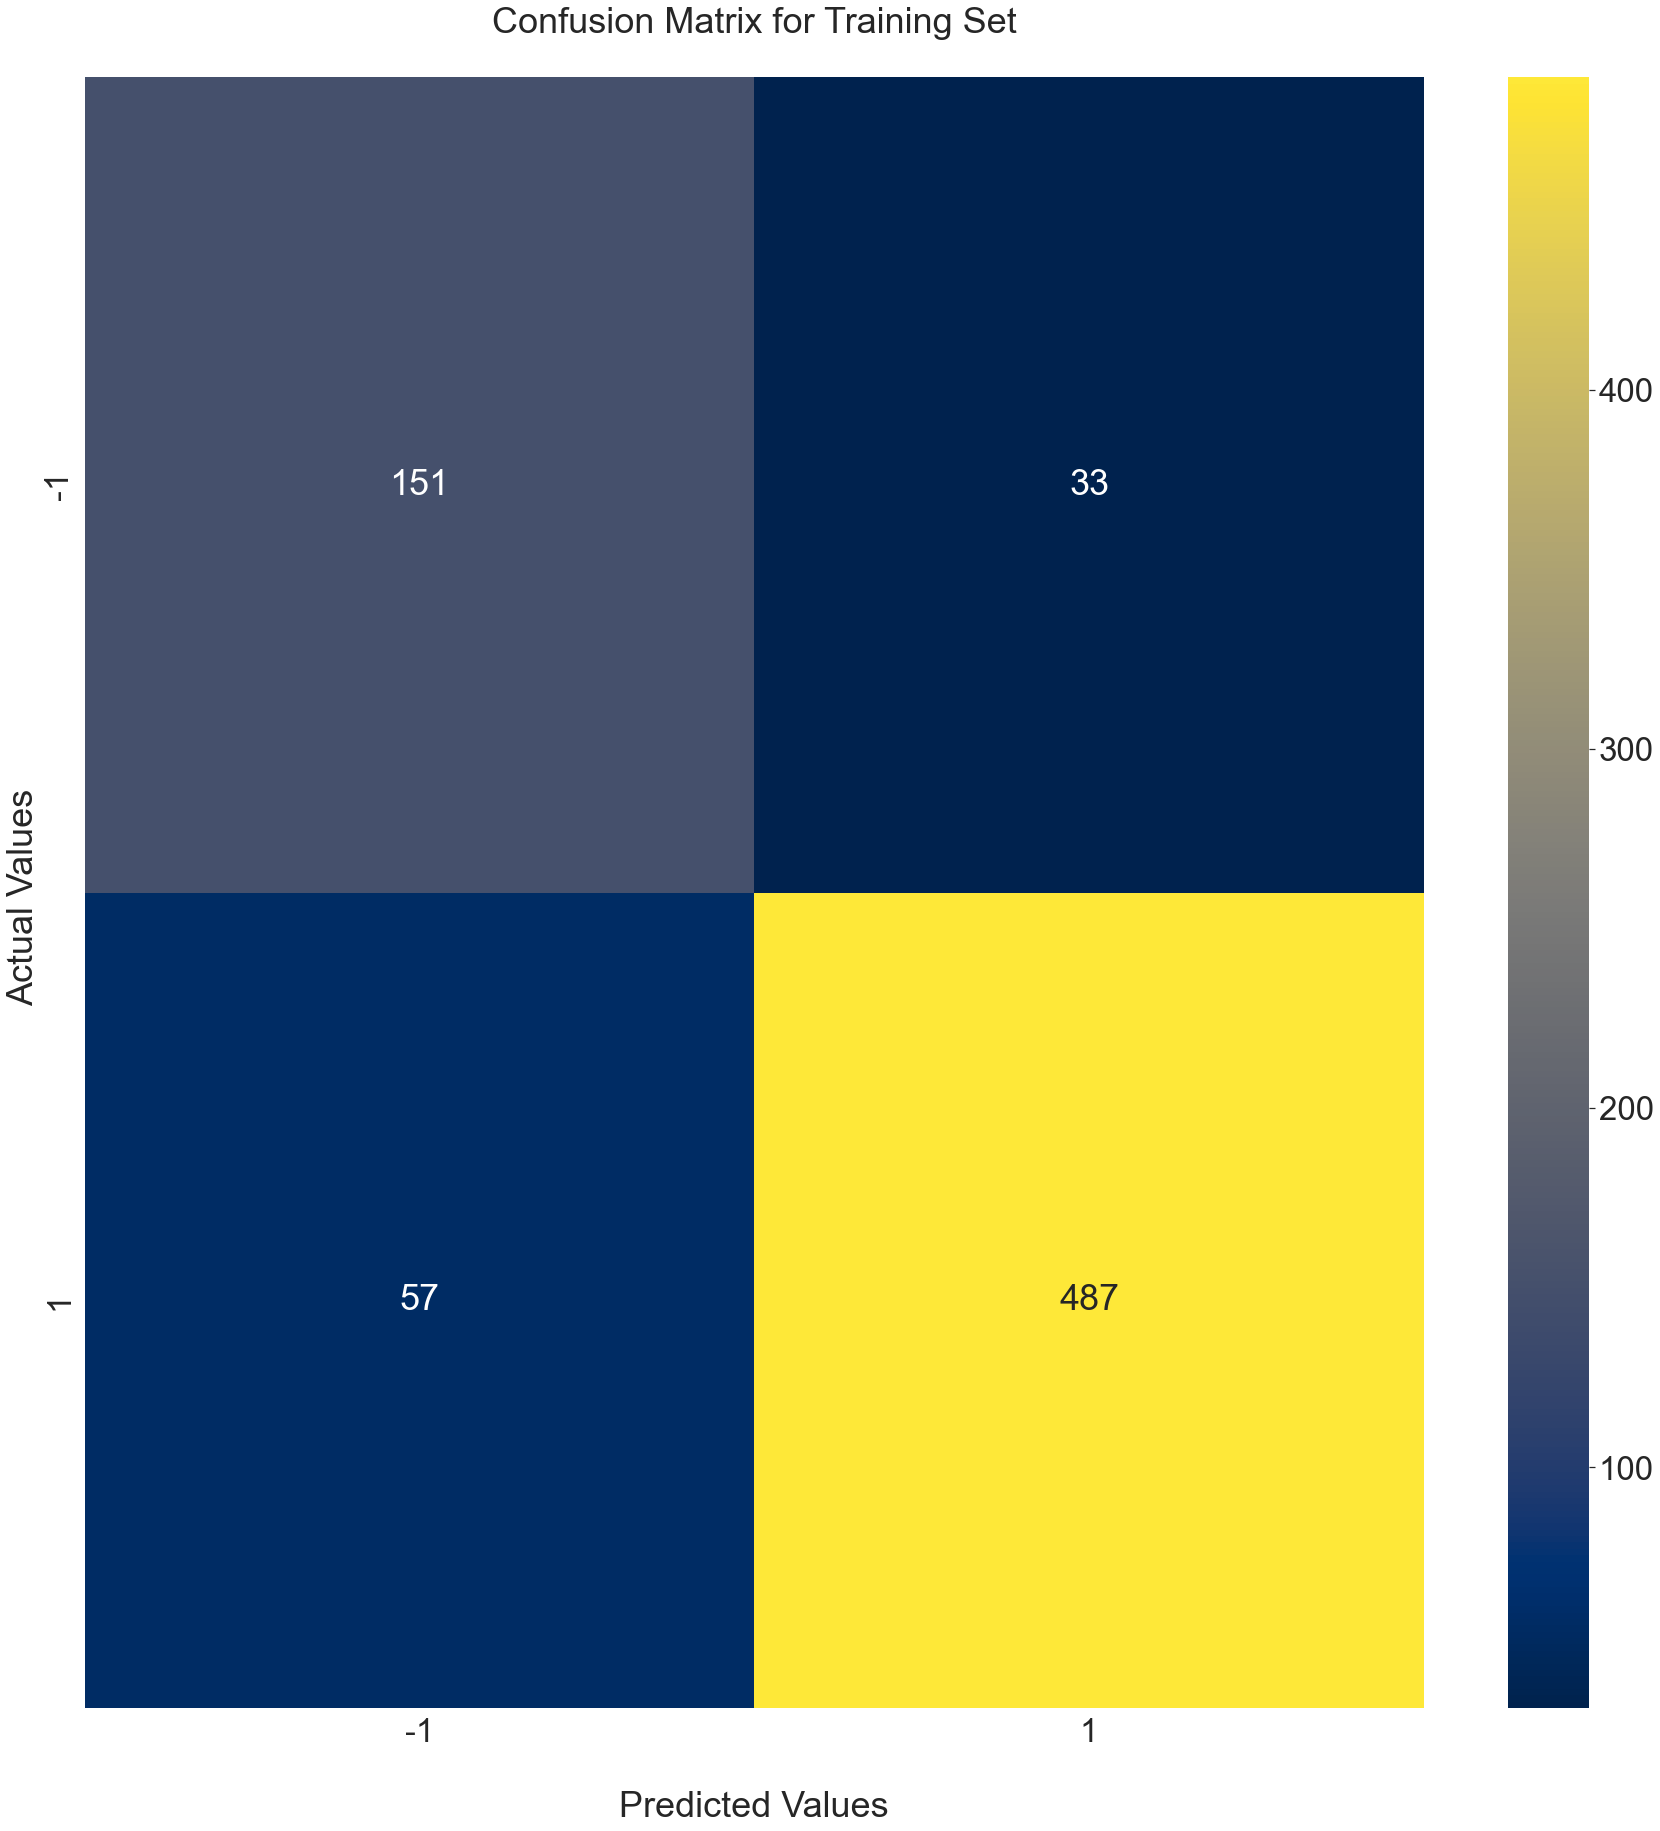

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [ ]:

# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

0.9614715315916195

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

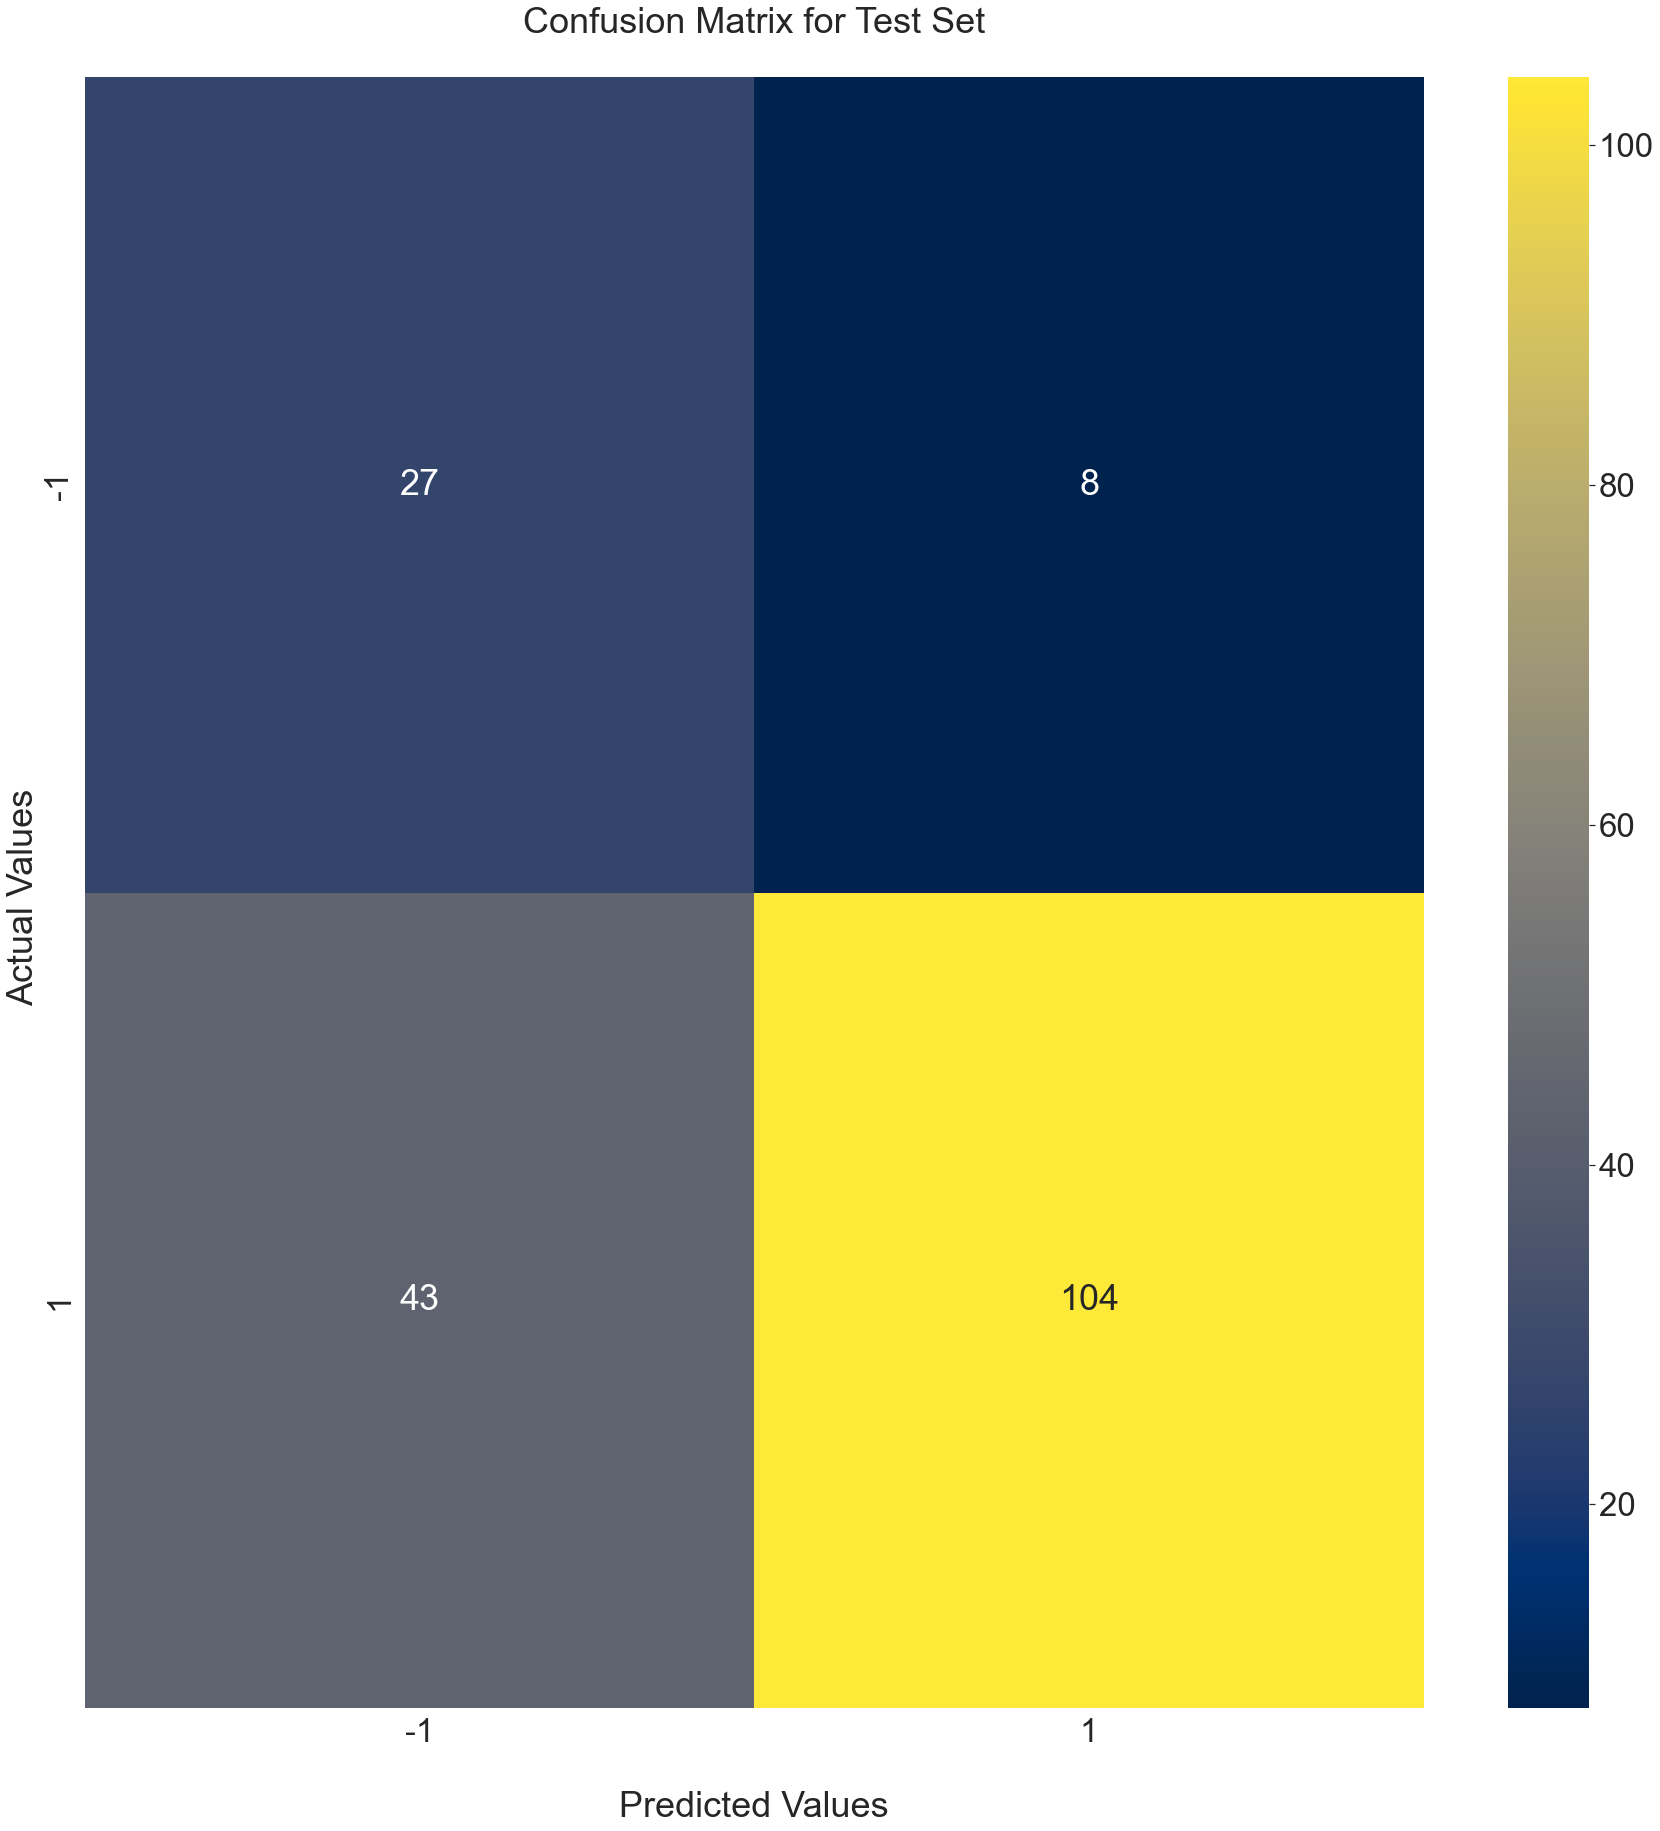

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0]
cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], np.select([pred<=0, pred>0], [-1, 1], 0))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['-1', '1'])
ax.yaxis.set_ticklabels(['-1', '1'])
ax

In [ ]:
# Recommender system for a random user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_item_based_CF(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User 877:


# User-based Collaborative Filtering with Jaccard Similarity

In [ ]:
# Keep the ratings in binary values only
user_ratings_df = user_ratings_df.replace(-1, 0)
train_user_ratings_df = train_user_ratings_df.replace(-1, 0)
train_user_ratings = train_user_ratings.replace(-1, 0)
test_user_ratings = test_user_ratings.replace(-1, 0)

In [ ]:
train_user_ratings_df

ProfileID,1,2,17,18,26,28,31,35,38,41,...,971,972,973,974,975,979,981,982,989,998
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import scipy.spatial

jaccard = scipy.spatial.distance.cdist(train_user_ratings_df, train_user_ratings_df, metric="jaccard")
sim_users_distance_df = pd.DataFrame(jaccard, index=train_user_ratings_df.index.values, columns=train_user_ratings_df.index.values)
sim_users_distance_df

,1,2,5,6,7,9,10,15,17,18,...,975,977,979,986,987,989,990,991,997,999
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
6,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
991,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
# Find nearest users with Jaccard distance

def findNearestUsersWithJaccard(user_id):
    # Extract the sorted distance of its neighbours for a user
    sim_users_distances_series = sim_users_distance_df[user_id].nsmallest(3)
    sim_users = [i for i in sim_users_distances_series.index]
    sim_users_distances = sim_users_distances_series.values.tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if user_id in sim_users:
        # The index of the user in the list of similar users
        index_of_user_in_sim = sim_users.index(user_id)

        # Remove the user from the list of similar users
        sim_users.pop(index_of_user_in_sim)

        # Remove the user from the list of similar users distances
        sim_users_distances.pop(index_of_user_in_sim)

    # print("The nearest users to User {} are:".format(user_id), ["User {}".format(i) for i in sim_users])
    # print("The distance from User {}:".format(user_id), sim_users_distances)
    return sim_users, sim_users_distances

# findNearestUsersWithJaccard(4)

In [ ]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = train_user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = train_user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    user_ratings = train_user_ratings_df.iloc[index_of_user].values.tolist()

    # Find the nearest neighbors of the user
    sim_users, sim_users_distances = findNearestUsersWithJaccard(user_id)
    
    # Get the ratings for the similar users
    sim_users_ratings = [train_user_ratings_df.loc[i].values.tolist() for i in sim_users]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_users_distances[i] * (sim_users_ratings[i][index_of_profile] - average(train_user_ratings_df.loc[sim_users[i]].values.tolist())) for i in range(len(sim_users))])
    denominator = sum(sim_users_distances)

    if denominator > 0:
        predicted_rating = average(user_ratings) + numerator / denominator 
    else:
        predicted_rating = average(user_ratings)

    # print("Returned", sim_users, sim_users_distances)
    # print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(3, 11)

In [ ]:
def recommender_system_user_based_CF_Jaccard(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        # if user_ratings_df.T.loc[profile_id, user_id] == 0:
        predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
        recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [ ]:
# Generating the entire user-based jaccard prediction matrix
predicted_ratings = train_user_ratings_df.T.copy()

for user_id in train_user_ratings_df.index:
    recommender_system_user_based_CF_Jaccard(user_id)
pd.DataFrame(predicted_ratings)

UserID,1,2,5,6,7,9,10,15,17,18,...,975,977,979,986,987,989,990,991,997,999
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
2,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
17,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
18,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
26,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
981,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0
982,0.004484,0.004484,0.0,0.004484,0.004484,0.018972,0.0,0.004484,-0.018409,0.0,...,0.0,0.004484,0.0,0.0,0.004484,-0.001495,0.0,0.0,0.004484,0.0


In [ ]:
# Turn pivot like table to original dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings.to_records())
predicted_ratings_df = predicted_ratings_df.melt(id_vars=["ProfileID"], var_name="UserID", value_name="Rating")
predicted_ratings_df = predicted_ratings_df.astype({"UserID": int, "ProfileID": int, "Rating": float})
predicted_ratings_df = predicted_ratings_df[["UserID", "ProfileID", "Rating"]]
predicted_ratings_df

,UserID,ProfileID,Rating
0,1,1,0.004484
1,1,2,0.004484
2,1,17,0.004484
3,1,18,0.004484
4,1,26,0.004484
...,...,...,...
105251,999,979,0.000000
105252,999,981,0.000000
105253,999,982,0.000000
105254,999,989,0.000000


In [ ]:
test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index()

Rating
UserID ProfileID        
1      133             1
       971             1
5      907             1
9      55              1
       531             1
...                  ...
961    328             1
968    328             1
969    133             0
991    103             0
999    554             1

[182 rows x 1 columns]

In [ ]:
# Get only ratings that UserID and ProfileID exist in train_user_ratings
predicted_ratings_for_train = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(train_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().head()

,,Rating
UserID,ProfileID,
1,720,0.004484
2,133,0.004484
6,328,0.004484
7,328,0.004484
9,57,0.018972


In [ ]:
# Get only ratings that UserID and ProfileID exist in test_user_ratings
predicted_ratings_for_test = predicted_ratings_df[predicted_ratings_df.set_index(["UserID", "ProfileID"]).index.isin(test_user_ratings.set_index(["UserID", "ProfileID"]).index)]
predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().head()

Rating
UserID ProfileID          
1      133        0.004484
       971        0.004484
5      907        0.000000
9      55         0.480511
       531        0.480511

In [ ]:
# Calculate the root mean squared error (RMSE) on the test set

from sklearn.metrics import mean_squared_error

# Root mean squared error for the training set
rmse_train = np.sqrt(mean_squared_error(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_train.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_train

0.7110804034138645

<AxesSubplot:title={'center':'Confusion Matrix for Training Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

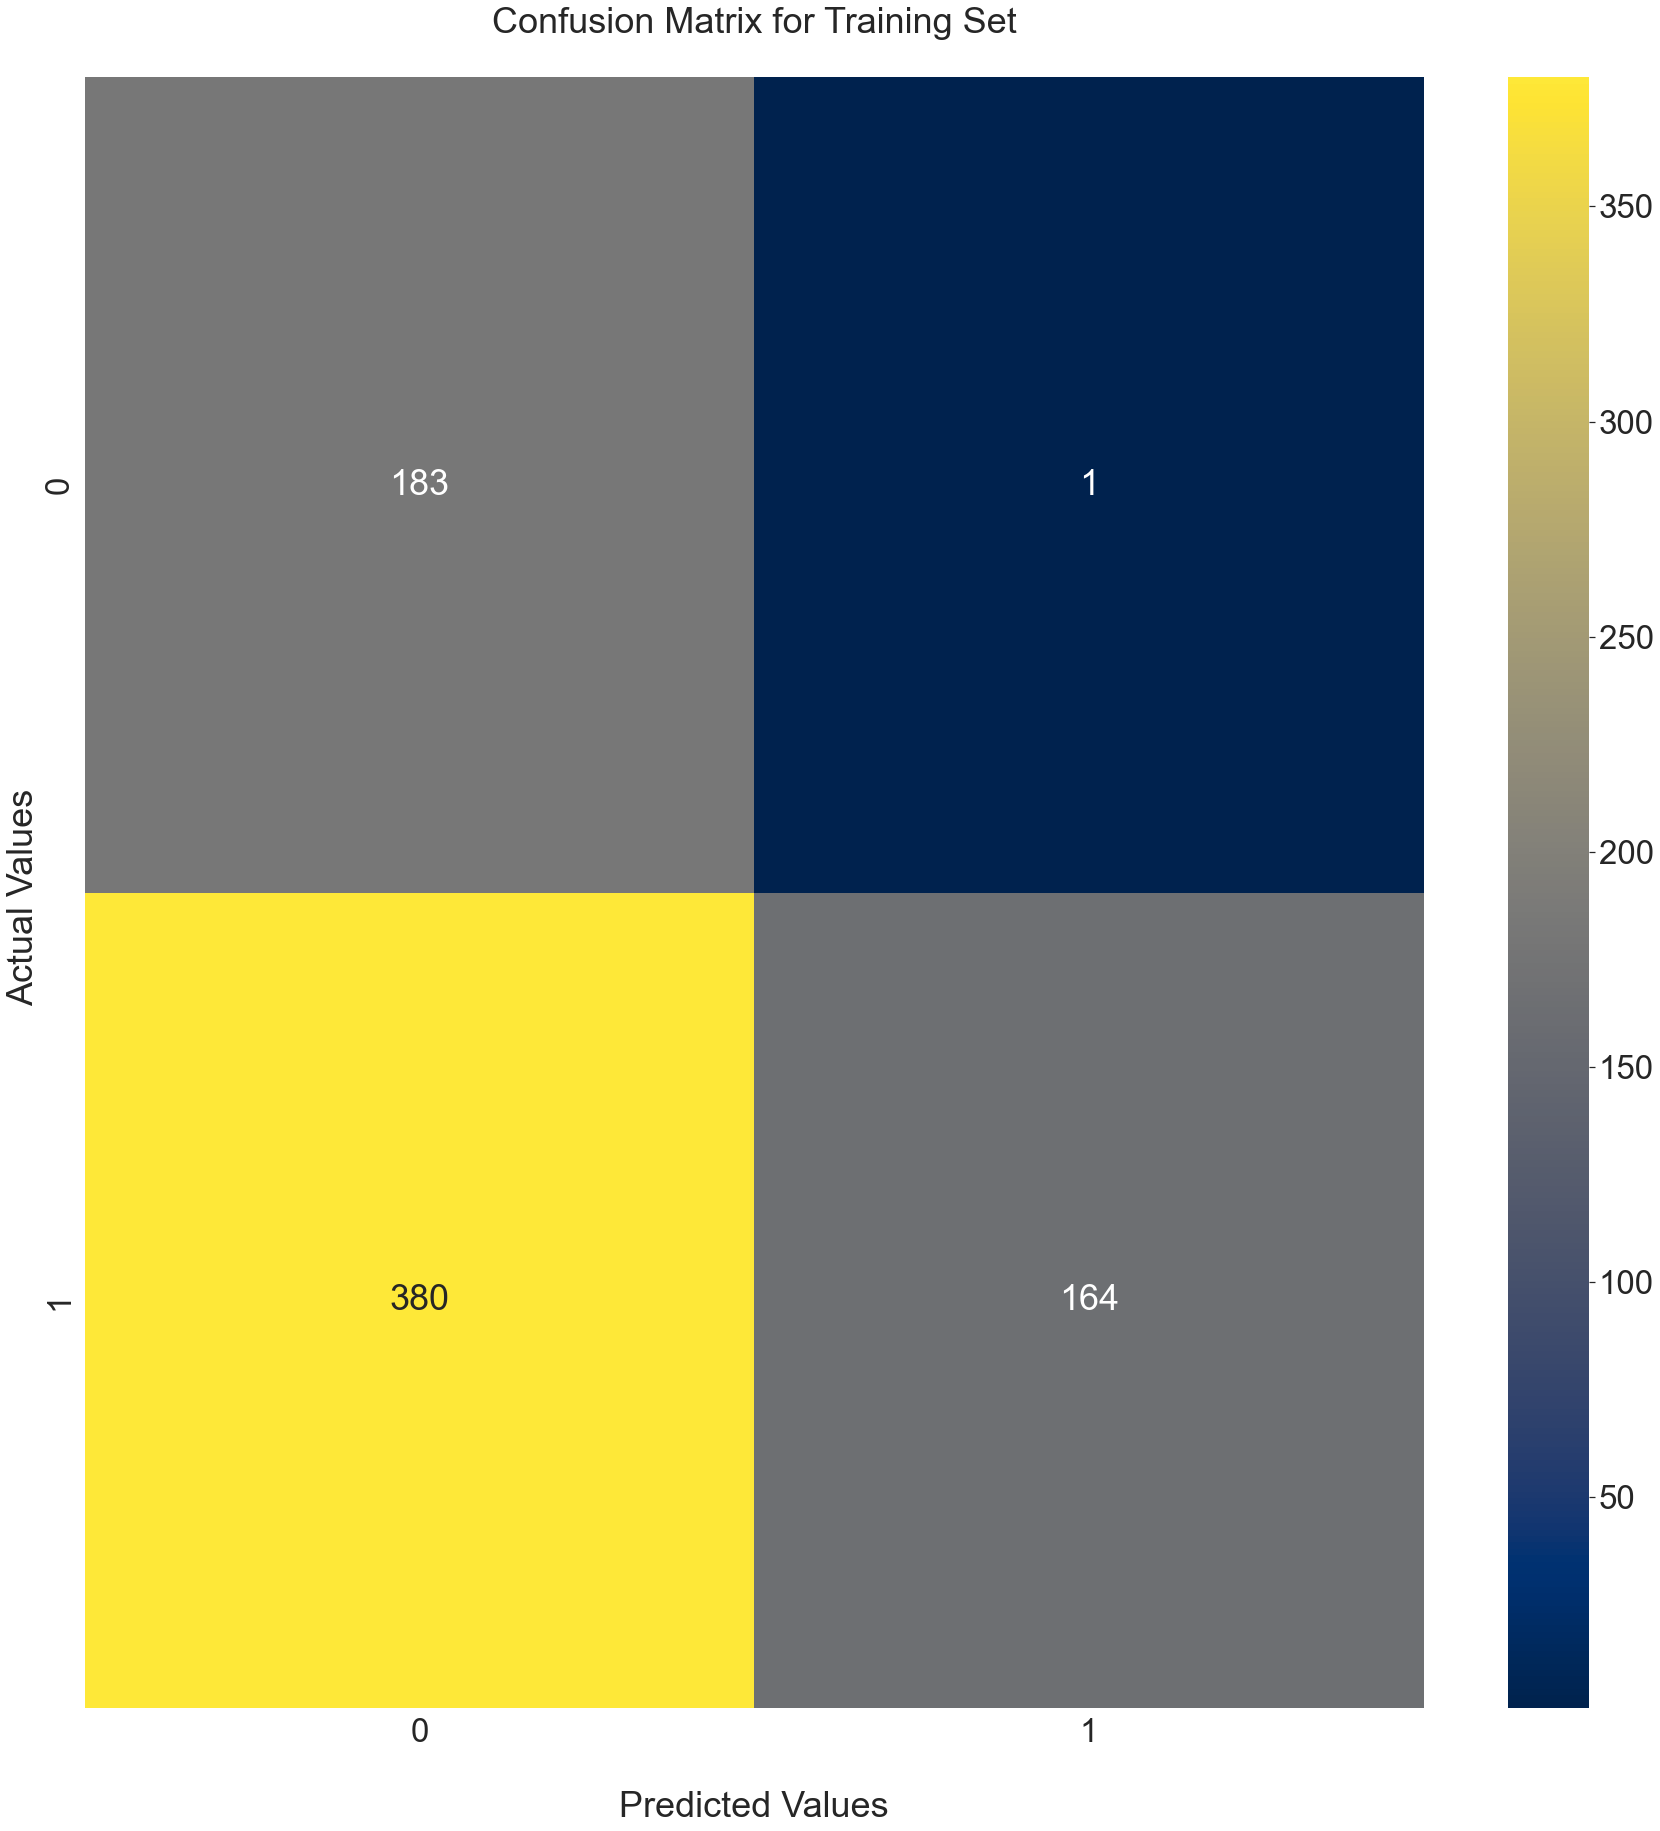

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(train_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_train.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Training Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [ ]:
# Root mean squared error for the test set
rmse_test = np.sqrt(mean_squared_error(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values, predicted_ratings_for_test.set_index(["UserID", "ProfileID"]).sort_index().values))
rmse_test

0.863595062956747

<AxesSubplot:title={'center':'Confusion Matrix for Test Set\n'}, xlabel='\nPredicted Values', ylabel='Actual Values '>

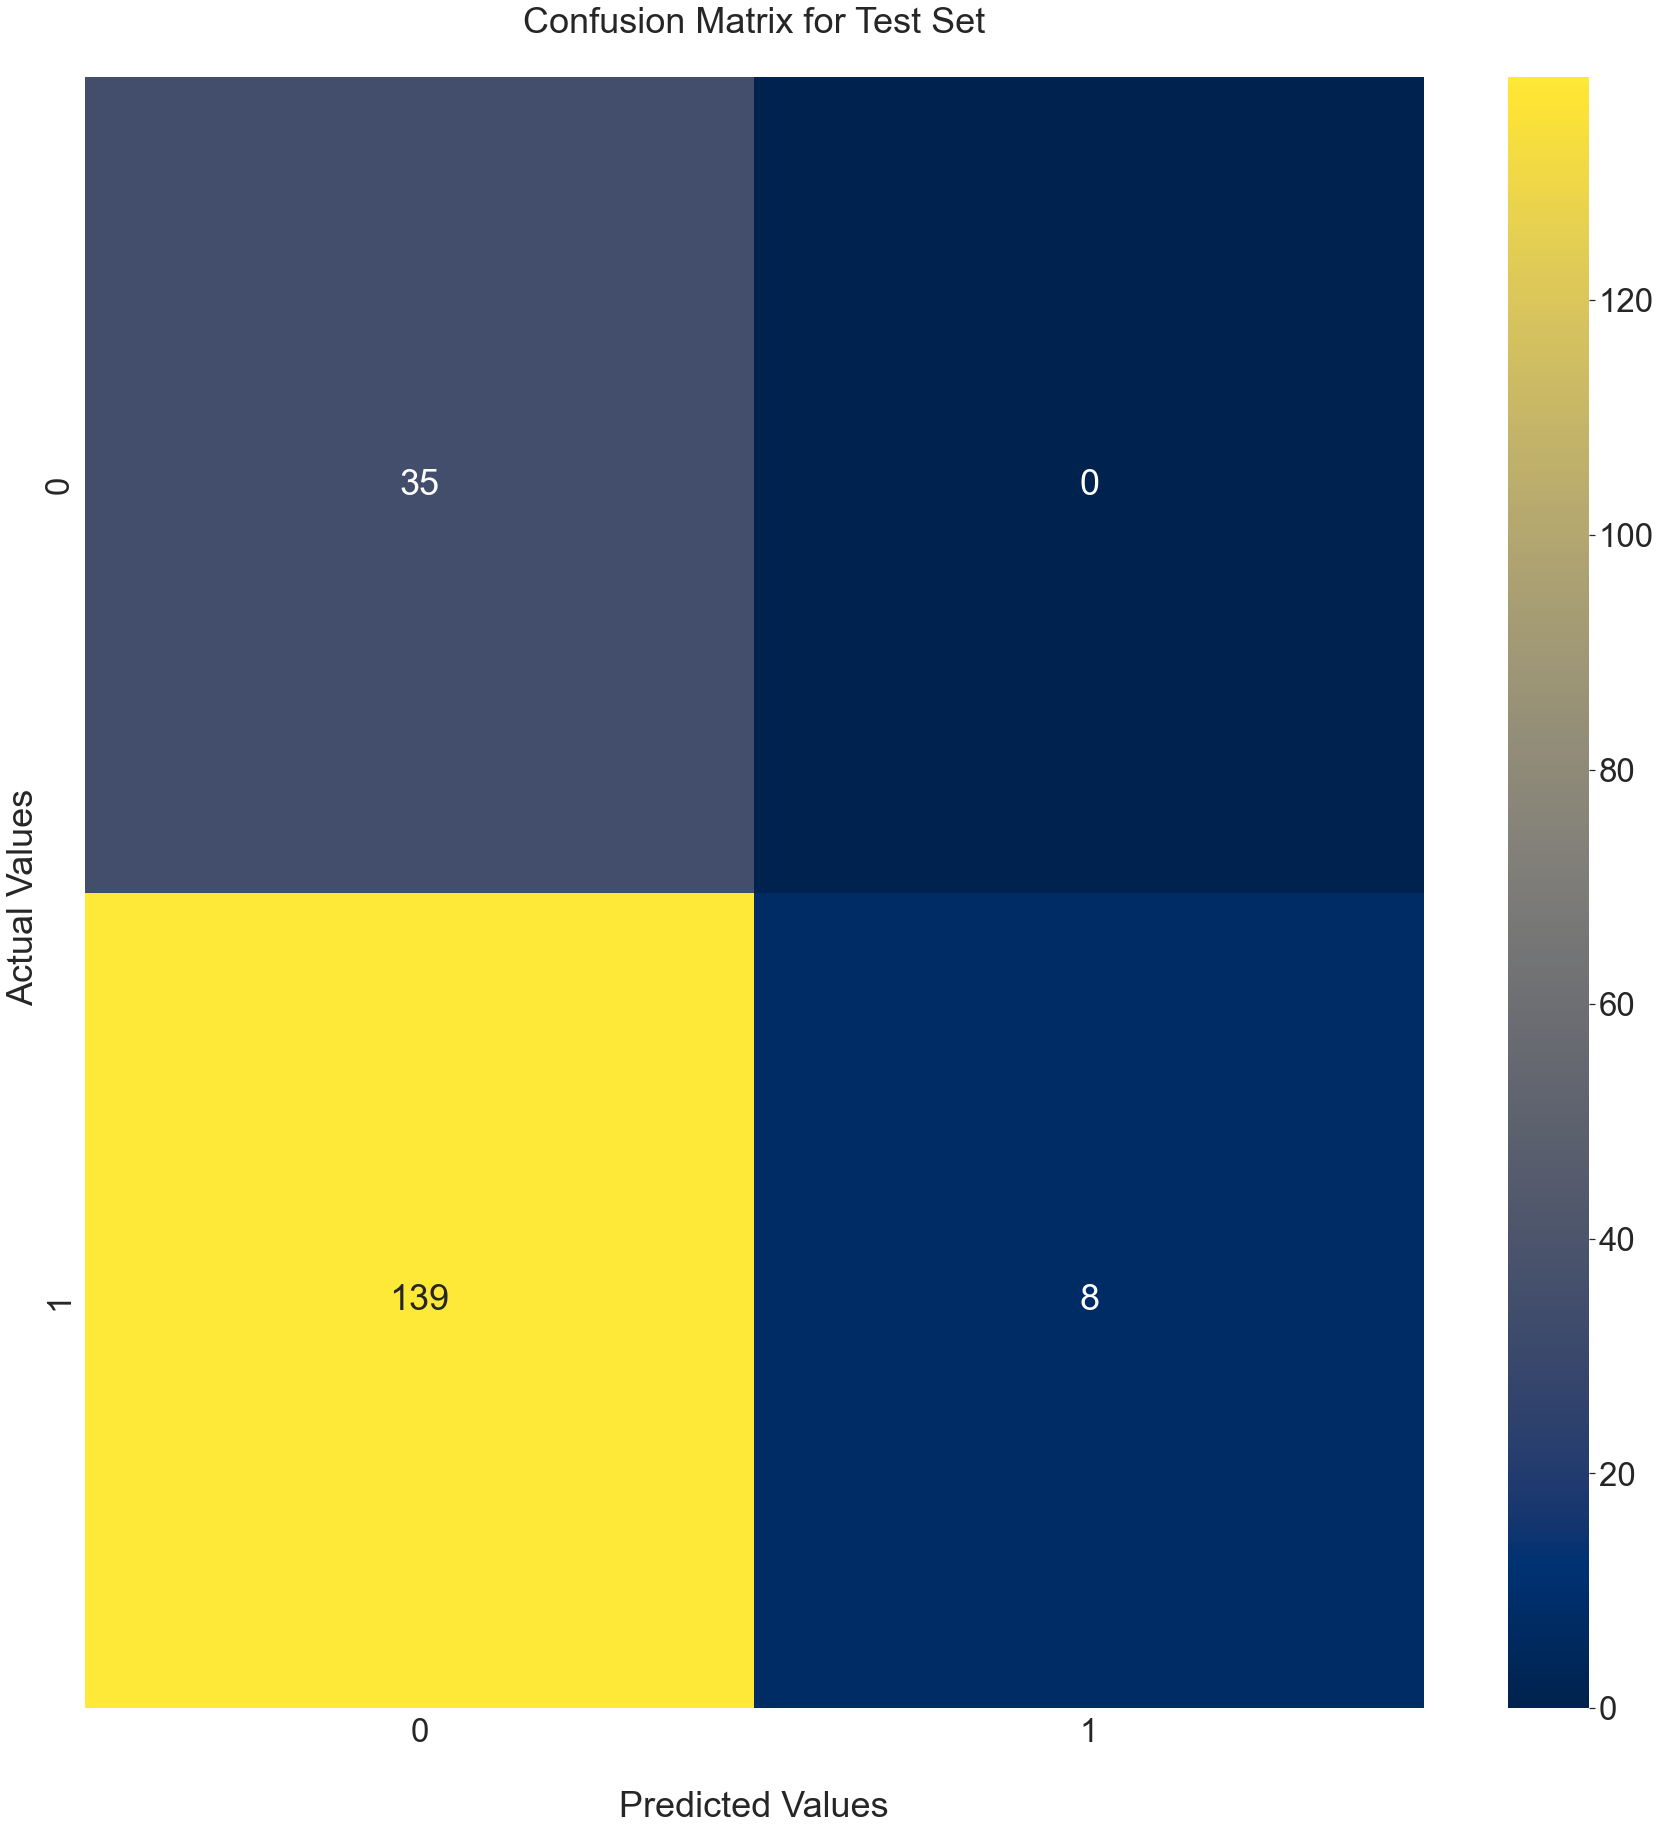

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(test_user_ratings.set_index(["UserID", "ProfileID"]).sort_index().values[:, 0], predicted_ratings_for_test.round(decimals = 0).set_index(["UserID", "ProfileID"]).sort_index().values[:, 0].astype(int))

sns.set(rc={'figure.figsize':(30,30)})
sns.set(font_scale=3.0)

ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis', xticklabels=True, yticklabels=True, fmt='g')
ax.set_title('Confusion Matrix for Test Set\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
ax

In [ ]:
# Recommender system for a user

import random

predicted_ratings = user_ratings_df.T.copy()

user_id = random.choice(user_ratings_df.index)

# Create recommendations
recommendations = recommender_system_user_based_CF_Jaccard(user_id)

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

# Select profile with value not equal to 0
user_rated_profiles = user_ratings_df.loc[user_id, user_ratings_df.loc[user_id, :] != 0].index.tolist()

# Remove the profile where the user has already rated and not itself
recommendations = [recommendation for recommendation in recommendations if recommendation[0] not in user_rated_profiles and recommendation[0] != user_id]

# Remove the profile where predicted rating is below 0.2
recommendations = [recommendation for recommendation in recommendations if recommendation[1] > 0.2]

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User 138:


# Visualize the network graph

Using the non pivot version (ratings) to visualize.

In [486]:
# Keep only "like" edges
ratings = ratings[ratings["Rating"] == 1]

## For small dataset visualization

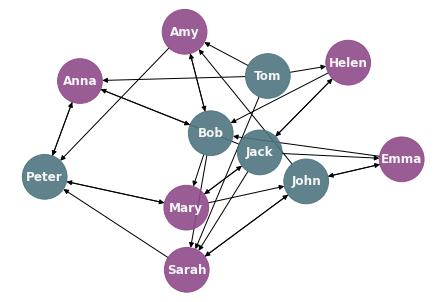

In [492]:
# Remarks: This won't plot node without positive rating associated with it.
# As negative rating has been remove before

import matplotlib.pyplot as plt
import networkx as nx

gr = nx.from_pandas_edgelist(ratings, "UserID", "ProfileID", "Rating", create_using=nx.DiGraph())

mapping = dict(info[["UserID", "Name"]].values.tolist())
color_map = []
for node in gr.nodes():
    if info.loc[info["UserID"] == node, "Gender"].values[0] == "M":
        color_map.append([0.3, 0.46, 0.5, 0.9])
    else:
        color_map.append([0.56, 0.29, 0.54, 0.9])

gr = nx.relabel_nodes(gr, mapping)
pos = nx.fruchterman_reingold_layout(gr)
nx.draw(gr, pos, with_labels=True, node_size=2000, node_color=color_map, font_color="whitesmoke", font_weight="semibold")
plt.show()

## For large dataset visualization

In [99]:
# Only execute this with large dataset

import graph_tool.all as gt 
import random
from IPython.display import Image

network_graph_file = "network-graph-" + str(random.randint(0, 2e9)) + ".png"

g = gt.Graph(directed=True)
vmap = g.add_edge_list(ratings[["UserID", "ProfileID"]].to_numpy(), hashed=True)
pos = gt.fruchterman_reingold_layout(g, n_iter=10)

v_size = g.new_vertex_property("double")
g.vertex_properties["v_size"] = v_size

v_font_size = g.new_vertex_property("double")
g.vertex_properties["v_font_size"] = v_font_size

v_pen_width = g.new_vertex_property("double")
g.vertex_properties["v_pen_width"] = v_pen_width
 
for v in g.vertices():
    v_size[v] = (1 + v.in_degree() * 4) * (1000 / g.num_vertices())
    v_font_size[v] = (1 + v.in_degree()) * (400 / g.num_vertices())
    v_pen_width[v] = (1 + v.in_degree()) * (100 / g.num_vertices())

gt.graph_draw(g, vertex_text=vmap, pos=pos, vertex_size=v_size, vertex_font_size=v_font_size, vertex_fill_color=[0.2, 0.4, 0.53, 0.9], vertex_pen_width=v_pen_width, vertex_font_family="roboto", output_size=(2048, 2048), bg_color=[1, 1, 1, 1], output=network_graph_file)

Image(url=network_graph_file)

# Below are the cells that I haven't finished yet.

In [ ]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# def standardize(row):
#     new_row = (row - row.mean()) / (row.max() - row.min())
#     return new_row

# user_ratings_std = user_ratings.apply(standardize)
# user_ratings_std

In [32]:
# Profile-Profile Similarity with Cosine similarity

def calculate_similarity(data):
    similarity = cosine_similarity(data)
    return similarity

profile_similarity = calculate_similarity(user_ratings.T)
profile_similarity_df = pd.DataFrame(profile_similarity, index=user_ratings_df.columns.values, columns=user_ratings_df.columns.values)
profile_similarity_df

,1,2,5
1,1.000000,0.000000,0.707107
2,0.000000,1.000000,0.707107
5,0.707107,0.707107,1.000000


In [34]:
# Making recommendations

def get_similar_profile(profile_id, user_rating):
    similar_score = profile_similarity_df[profile_id] * user_rating
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

result = get_similar_profile(1, 1)
result


1    1.000000
5    0.707107
2    0.000000
Name: 1, dtype: float64